### Загружаем необходимые библиотеки

In [1]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 4.1 MB/s eta 0:00:00


In [62]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

### Загрузим текст произведения "Война и мир", оставив только строчные буквы и пробел

In [11]:
with open('tom_1.txt', 'r') as f:
    tom_1 = f.read().lower()
tom_1 = re.sub('[^а-яё ]','', tom_1)

with open('tom_2.txt', 'r') as f:
    tom_2 = f.read().lower()
tom_2 = re.sub('[^а-яё ]','', tom_2)

with open('tom_3.txt', 'r') as f:
    tom_3 = f.read().lower()
tom_3 = re.sub('[^а-яё ]','', tom_3)

with open('tom_4.txt', 'r') as f:
    tom_4 = f.read().lower()
tom_4 = re.sub('[^а-яё ]','', tom_4)

In [12]:
text = tom_1 + tom_2 + tom_3 + tom_4

### Построим матрицу переходных вероятностей

In [13]:
Russian = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(Russian)}

In [14]:
probabilities = np.zeros((len(Russian), len(Russian)))

In [15]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [16]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [17]:
df = pd.DataFrame(probabilities, index=(c for c in Russian), columns=(c for c in Russian))

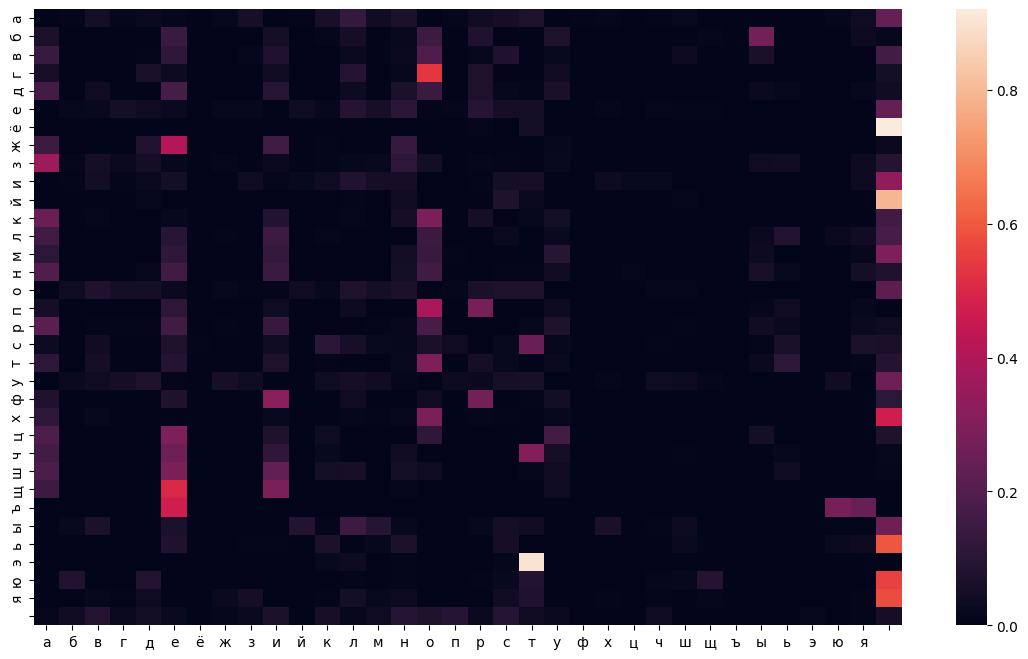

In [18]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

### Посчитайте вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р».

In [19]:
start = POS['п']
end = POS['р']
prior = 1. / len(Russian)
for c in Russian:
  for l in Russian:
    proba = prior * probabilities[start, POS[c]] * probabilities[POS[c], POS[l]] * probabilities[POS[l], end]
    if proba > 0:
        print(''.join(['п', c, l, 'р']), proba)

паар 1.2483021244621608e-08
пабр 1.0155553856672825e-06
павр 1.15917977686471e-06
пагр 1.2848114697473956e-06
падр 2.942105165838902e-06
паер 1.9503146628298786e-06
пажр 7.311949848239609e-09
пазр 1.2095790878783555e-06
паир 2.547790864803073e-08
пайр 2.7599678947720997e-08
пакр 4.83849984690539e-06
палр 3.3611556905914123e-09
памр 1.0930948458598652e-07
панр 1.161326477180596e-07
паор 4.339681014540716e-08
папр 5.626388035700382e-06
парр 2.870279020272537e-08
паср 5.043304580053417e-07
патр 5.524111015460852e-06
паур 6.923602698965342e-08
пафр 3.17685218286211e-06
пахр 2.440818119506081e-07
пачр 2.6506060145138035e-08
пашр 5.266004634220631e-09
пащр 4.5451641687422465e-09
паэр 3.402682747656317e-10
паюр 1.6147067665876867e-07
паяр 1.4938299828069804e-07
па р 8.69681409376144e-06
пвар 2.806393138584855e-09
пвбр 1.5943951085774744e-11
пввр 8.160012706997085e-12
пвгр 3.321084346893555e-11
пвдр 2.682355228700592e-10
пвер 5.0598785244545456e-09
пвёр 5.843288720706058e-14
пвжр 3.90939163635

### Используя матрицу переходных вероятностей, сгенерируйте слово, начинающееся с буквы «Б» длиной восемь символов.

In [29]:
s = []
start = 'б'
s.append(start)
length = 8
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(Russian), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

бещеродул


### Выберите временной ряд и оцените его через HMM.

In [30]:
passengers = pd.read_csv('international-airline-passengers.csv')
passengers.head()

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [63]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print(dftest[1])

In [64]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
0.991880243437641


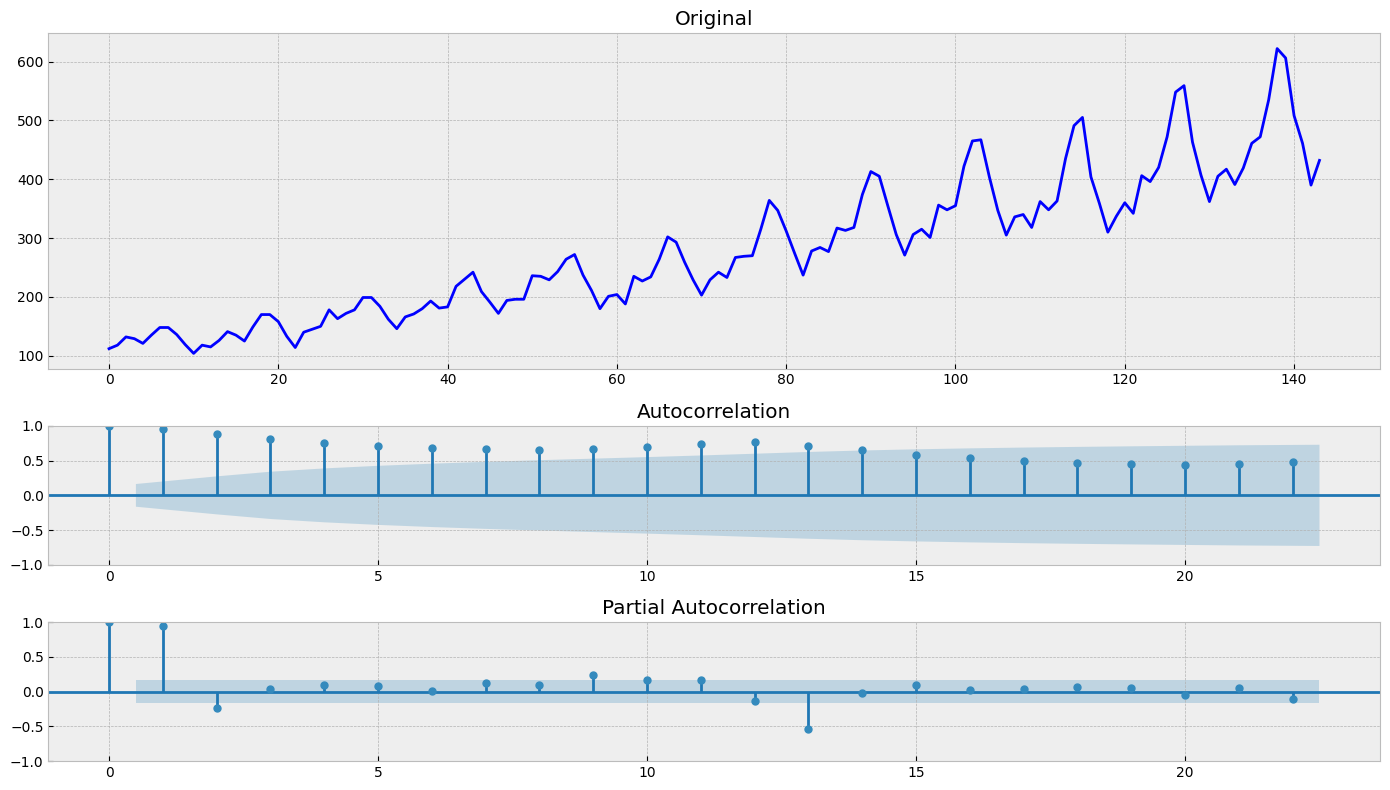

In [65]:
tsplot(passengers['Count'])

Временной ряд нестационарен, имеет сезонность равную 12 и восходящий тренд

In [70]:
#Нормализуем дисперсию
ts = boxcox(passengers['Count'], 0)
#Дифференцируем для устранения тренда и сезонности
ts = np.diff(ts)
ts = np.diff(ts, 12)

Results of Dickey-Fuller Test:
5.255377690806885e-29


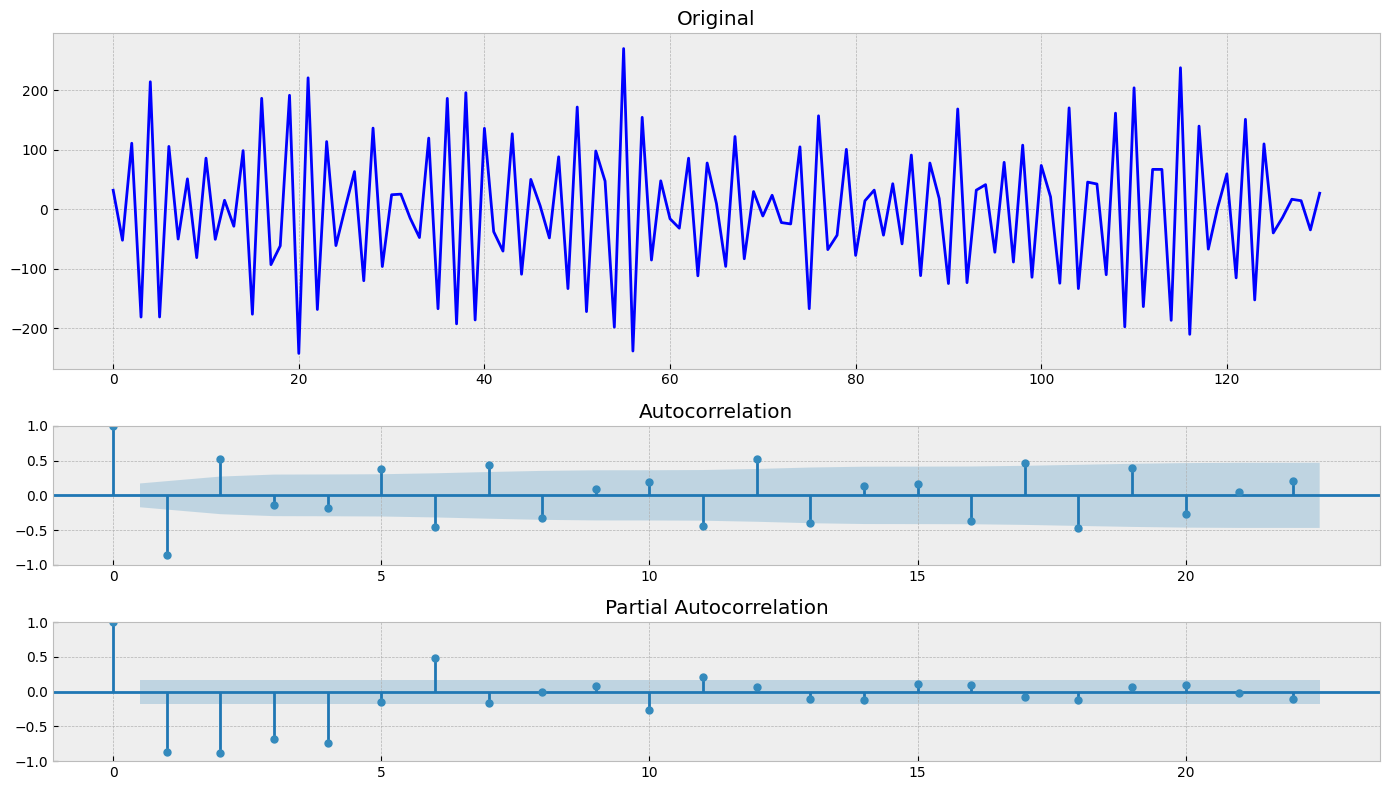

In [71]:
tsplot(ts)

### Попробуйте построить через среднее каждой компоненты наивный прогноз ряда.

In [73]:
values = ts.reshape(-1,1)

In [74]:
values.shape

(131, 1)

In [75]:
train, test = values[:110], values[110:]

In [77]:
for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(train)
    print (n, model.score(train))

1 -678.4628526243023
2 -648.5140793557065
3 -632.0823358118272
4 -621.0646641380647
5 -611.0155299139375
6 -591.8768178903658


7 -598.7902376770338
8 -589.6861720468901
9 -574.4796711979295
10 -583.0034653280219


11 -564.5068761890246
12 -564.029423619279
13 -556.8139482043815


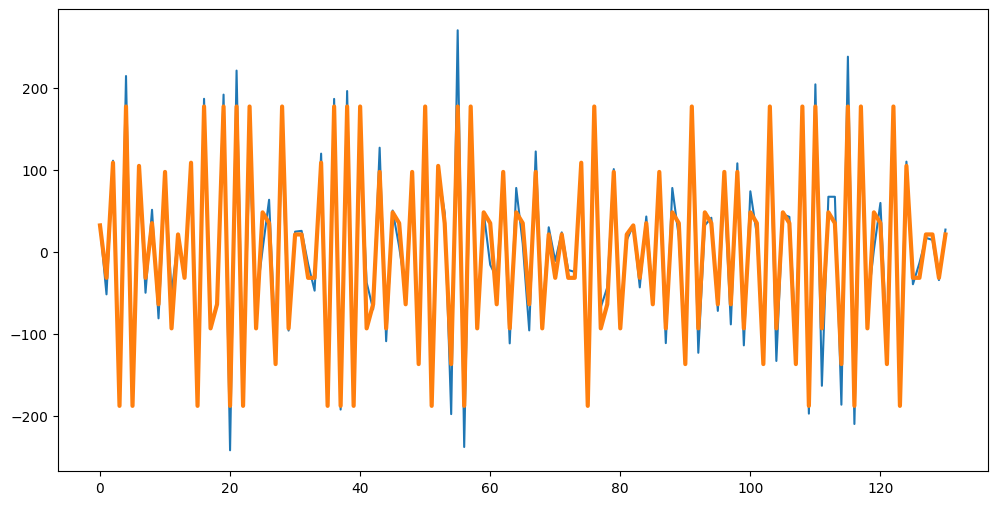

In [78]:
model = GaussianHMM(n_components=13,
                        covariance_type="diag",
                        n_iter=10000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]

plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)